In [146]:
import h5py
import numpy as np
from skimage.transform import resize
from skimage import color
from skimage import segmentation
import matplotlib.pyplot as plt
import time
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    size = vol.shape[1]
    # reshape for labeling
    seg = np.reshape(seg, (size, length*size) )
    vol = np.reshape(vol, (size, length*size) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=0)
    # shape back
    labeled = np.reshape(labeled, (length, size, size, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i])
    axarr[1,1].imshow(patch.affinity[1][i])
    axarr[1,2].imshow(patch.affinity[2][i])
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
from neutorch.dataset.affinity import Dataset
from neutorch.dataset.ground_truth_volume import *

dataset = Dataset('../../data', patch_size=(10,10,10), length=100)

loading file sample_A...


In [165]:
patch = dataset.random_training_patch
affinity = patch.affinity
label = patch.label

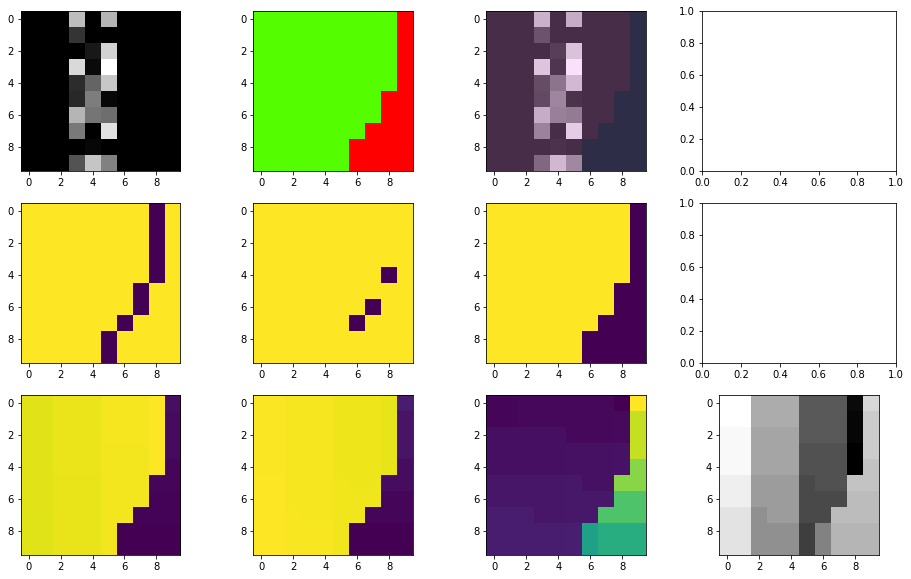

[  8071.  11715.  26202. 129625. 154269. 154270.]


In [166]:
view_patch(patch)
print(np.unique(label))

In [120]:
from waterz import agglomerate
import numpy as np


# affs is a [3, z, y, x] numpy array of float32
affs = np.flip(affinity, axis=0)
affs = np.ascontiguousarray(affs, dtype=np.float32) 
ground_truth = None
thresholds = [ 0.7 ]
seg_generator = agglomerate(affs, thresholds, gt=ground_truth,
        aff_threshold_low=0.001,
        aff_threshold_high=0.9999,
        return_merge_history=False,
        return_region_graph=False)

Re-using already compiled waterz version


In [121]:
seg = next(seg_generator)
print(np.count_nonzero(seg-1))

Preparing segmentation volume...
2


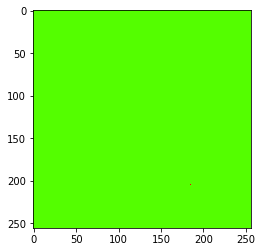

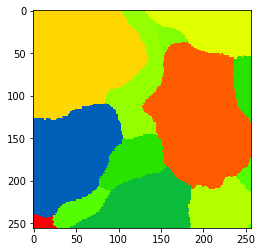

In [122]:
plt.imshow(seg[0], cmap='prism')
plt.show()
plt.imshow(label[0][0], cmap='prism')
plt.show()